Возьмите базу трафика с сайта компании. Напишите модель для прогнозирования трафика. 

Возьмите xLen = 60. Добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

#Прогнозирование трафика





In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
import re

import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/MyDrive/Базы/traff.csv', sep=';')

In [ ]:
#Выводим пять первых строк
base_data.head()

,"1/1/2017,""22,226.00"""
0,"1/2/2017,""29,593.00"""
1,"1/3/2017,""31,726.00"""
2,"1/4/2017,""32,684.00"""
3,"1/5/2017,""31,820.00"""
4,"1/6/2017,""29,354.00"""


In [ ]:
traff = base_data.values
traff


array([['1/2/2017,"29,593.00"'],
       ['1/3/2017,"31,726.00"'],
       ['1/4/2017,"32,684.00"'],
       ...,
       ['12/29/2019,"37,665.00"'],
       ['12/30/2019,"32,643.00"'],
       ['12/31/2019,"28,212.00"']], dtype=object)

In [ ]:
base_data[0] = base_data
base_data[1] = base_data[0]
base_data

,"1/1/2017,""22,226.00""",0,1
0,"1/2/2017,""29,593.00""","1/2/2017,""29,593.00""","1/2/2017,""29,593.00"""
1,"1/3/2017,""31,726.00""","1/3/2017,""31,726.00""","1/3/2017,""31,726.00"""
2,"1/4/2017,""32,684.00""","1/4/2017,""32,684.00""","1/4/2017,""32,684.00"""
3,"1/5/2017,""31,820.00""","1/5/2017,""31,820.00""","1/5/2017,""31,820.00"""
4,"1/6/2017,""29,354.00""","1/6/2017,""29,354.00""","1/6/2017,""29,354.00"""
...,...,...,...
1089,"12/27/2019,""29,801.00""","12/27/2019,""29,801.00""","12/27/2019,""29,801.00"""
1090,"12/28/2019,""34,913.00""","12/28/2019,""34,913.00""","12/28/2019,""34,913.00"""
1091,"12/29/2019,""37,665.00""","12/29/2019,""37,665.00""","12/29/2019,""37,665.00"""
1092,"12/30/2019,""32,643.00""","12/30/2019,""32,643.00""","12/30/2019,""32,643.00"""


In [ ]:
traff.shape[0]

1094

In [ ]:
traff[0][0][:8]

'1/2/2017'

In [ ]:
traff[0][0][10:19]

'29,593.00'

In [ ]:
print(base_data.index[5:10])

RangeIndex(start=5, stop=10, step=1)


In [ ]:
ch=0
for i in range(traff.shape[0]):
  base_data[0][ch]=traff[ch][0][:10]
  ch+=1

In [ ]:
ch=0
for i in range(traff.shape[0]):
  base_data[1][ch]=traff[ch][0][-10:-1]
  ch+=1

In [ ]:
base_data

,"1/1/2017,""22,226.00""",0,1
0,"1/2/2017,""29,593.00""","1/2/2017,""","29,593.00"
1,"1/3/2017,""31,726.00""","1/3/2017,""","31,726.00"
2,"1/4/2017,""32,684.00""","1/4/2017,""","32,684.00"
3,"1/5/2017,""31,820.00""","1/5/2017,""","31,820.00"
4,"1/6/2017,""29,354.00""","1/6/2017,""","29,354.00"
...,...,...,...
1089,"12/27/2019,""29,801.00""",12/27/2019,"29,801.00"
1090,"12/28/2019,""34,913.00""",12/28/2019,"34,913.00"
1091,"12/29/2019,""37,665.00""",12/29/2019,"37,665.00"
1092,"12/30/2019,""32,643.00""",12/30/2019,"32,643.00"


In [ ]:
base_data[1] = pd.to_numeric(base_data[1].str.replace(r'[^\d%]',''))

In [ ]:
base_data[1] = base_data[1]/100
base_data

,"1/1/2017,""22,226.00""",0,1
0,"1/2/2017,""29,593.00""","1/2/2017,""",29593.0
1,"1/3/2017,""31,726.00""","1/3/2017,""",31726.0
2,"1/4/2017,""32,684.00""","1/4/2017,""",32684.0
3,"1/5/2017,""31,820.00""","1/5/2017,""",31820.0
4,"1/6/2017,""29,354.00""","1/6/2017,""",29354.0
...,...,...,...
1089,"12/27/2019,""29,801.00""",12/27/2019,29801.0
1090,"12/28/2019,""34,913.00""",12/28/2019,34913.0
1091,"12/29/2019,""37,665.00""",12/29/2019,37665.0
1092,"12/30/2019,""32,643.00""",12/30/2019,32643.0


In [ ]:
sumtraff = base_data[1]
sumtraff = np.array(sumtraff)
sumtraff.shape

(1094,)

In [ ]:
# Выводим параметры одного файла
d = sumtraff
print(len(d)) # Сколько есть записей
print(d.shape[0]) # Длина одной строки данных
print(d[0]) # Пример первой строки данных

1094
1094
29593.0


In [ ]:
sumtraff

array([29593., 31726., 32684., ..., 37665., 32643., 28212.])

In [ ]:
# Сравниваем размеры
print(len(base_data.index)) # Выводим размер первой базы

1094


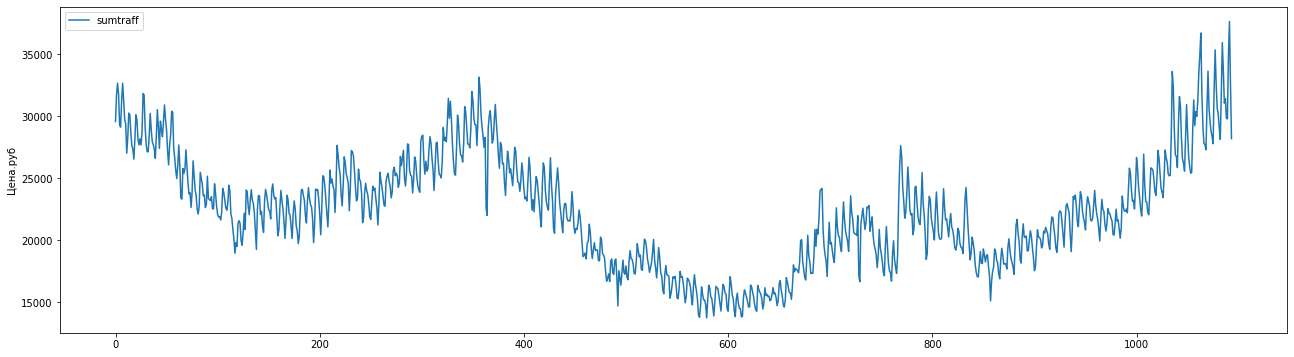

KeyError: ignored

<Figure size 1584x432 with 0 Axes>

In [ ]:
#Отображаем исходные от точки start и длинной stop
start = 100            #С какой точки начинаем
#stop = data.shape[0] #Сколько точек отрисуем
length = 300 #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['sumtraff']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
plt.figure(figsize=(22,6))
for i in range(1):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(base_data[1][base_data.index], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=base_data[1][base_data.index,1], label="Volume")
plt.legend()
plt.show()

### Использование TimeseriesGenerator

In [ ]:
import numpy as np # Подключаем numpy
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Подлкючаем модуль TimeseriesGenerator

In [ ]:
test_array = np.arange(1095) # Создаем тестовый массив из полседовательности чисел от 0 до 50
print(test_array) # Выводим на экран созданный массив

[   0    1    2 ... 1092 1093 1094]


In [ ]:
x_train = test_array # Создаем x_train
y_train = test_array # Создаем y_train

# Создаем генератор
gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 60,
    sampling_rate=1,
    stride=1,
    batch_size=5
    )

In [ ]:
# Формируем цикл for для прохождения по элементам генератора
for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

Батч № 0
x_train: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
  49 50 51 52 53 54 55 56 57 58 59 60]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
  26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
  50 51 52 53 54 55 56 57 58 59 60 61]
 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
  27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
  51 52 53 54 55 56 57 58 59 60 61 62]
 [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
  28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
  52 53 54 55 56 57 58 59 60 61 62 63]]
y_train: [60 61 62 63 64]

Батч № 1
x_train: [

In [ ]:
x_train = test_array[:-1] # Создаем x_train
y_train = test_array[1:] # Создаем y_train

# Создаем генератор
gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 60,
    sampling_rate=1,
    stride=1,
    batch_size=1
    )
# Формируем цикл for для прохождения по элементам генератора
for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

Выходные данные были обрезаны до нескольких последних строк (5000).
Батч № 333
x_train: [[333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
  351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
  369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
  387 388 389 390 391 392]]
y_train: [394]

Батч № 334
x_train: [[334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351
  352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369
  370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387
  388 389 390 391 392 393]]
y_train: [395]

Батч № 335
x_train: [[335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
  353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
  371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
  389 390 391 392 393 394]]
y_train: [396]

Батч № 336
x_train: [[336 337 338 339 340 341 342 343 344 345 346 347 348 

In [ ]:
x_train = test_array # Создаем x_train
y_train = [[x, x+1] for x in range(1095)] # Создаем y_train

# Создаем генератор
gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 60,
    sampling_rate=1,
    stride=1,
    batch_size=1
    )
# Формируем цикл for для прохождения по элементам генератора
for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

Выходные данные были обрезаны до нескольких последних строк (5000).
x_train: [[334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351
  352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369
  370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387
  388 389 390 391 392 393]]
y_train: [[394 395]]

Батч № 335
x_train: [[335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
  353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
  371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
  389 390 391 392 393 394]]
y_train: [[395 396]]

Батч № 336
x_train: [[336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
  354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371
  372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
  390 391 392 393 394 395]]
y_train: [[396 397]]

Батч № 337
x_train: [[337 338 339 340 341 342 343 344 345 346 347 3

In [ ]:
y_train = [[x, x+1] for x in range(1095)]
print(y_train)

[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20], [20, 21], [21, 22], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27], [27, 28], [28, 29], [29, 30], [30, 31], [31, 32], [32, 33], [33, 34], [34, 35], [35, 36], [36, 37], [37, 38], [38, 39], [39, 40], [40, 41], [41, 42], [42, 43], [43, 44], [44, 45], [45, 46], [46, 47], [47, 48], [48, 49], [49, 50], [50, 51], [51, 52], [52, 53], [53, 54], [54, 55], [55, 56], [56, 57], [57, 58], [58, 59], [59, 60], [60, 61], [61, 62], [62, 63], [63, 64], [64, 65], [65, 66], [66, 67], [67, 68], [68, 69], [69, 70], [70, 71], [71, 72], [72, 73], [73, 74], [74, 75], [75, 76], [76, 77], [77, 78], [78, 79], [79, 80], [80, 81], [81, 82], [82, 83], [83, 84], [84, 85], [85, 86], [86, 87], [87, 88], [88, 89], [89, 90], [90, 91], [91, 92], [92, 93], [93, 94], [94, 95], [95, 96], [96, 97], [97, 98], [98, 99], [99, 100], [100, 101], [101,

### Функция загрузки данных




In [ ]:
#Формируем параметры загрузки данных

xLen = 60                      #Анализируем по 300 прошедшим точкам 
valLen =1000                  #Используем 30.000 записей для проверки

trainLen = base_data[0].shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = np.reshape(base_data.index[:trainLen],(-1,1)), np.reshape(base_data.index[trainLen+xLen+2:],(-1,1))

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain, yTest = np.reshape(sumtraff[:trainLen],(-1,1)), np.reshape(sumtraff[trainLen+xLen+2:],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 60, 1) (20, 1)


In [ ]:
print(xTrain[:5])
print(yTrain[:5])

[[0.        ]
 [0.01075269]
 [0.02150538]
 [0.03225806]
 [0.04301075]]
[[0.70683453]
 [0.90874669]
 [0.99943203]
 [0.91764483]
 [0.68421053]]


In [ ]:
print(len(xTrain))
print(len(xTest))
print(len(yTrain))
print(len(yTest))
print(len(trainDataGen))

94
938
94
938
2


## Полносвязная сеть




## Визуализация результатов


In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=60, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Dense-сетка

### Эксп. №1

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,1), activation="relu" )) # 1 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelD.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 60, 150)           300       
                                                                 
 flatten_10 (Flatten)        (None, 9000)              0         
                                                                 
 dense_17 (Dense)            (None, 1)                 9001      
                                                                 
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________


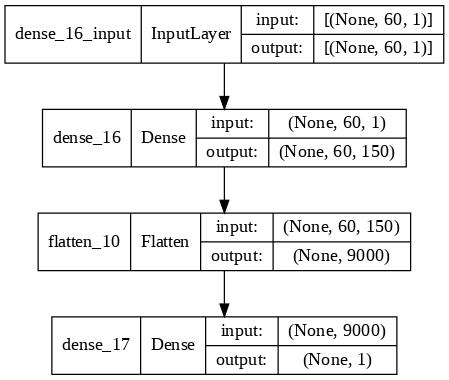

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(modelD, dpi=90,  show_shapes=True)

In [ ]:
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=150, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/150
2/2 [==============================] - 1s 223ms/step - loss: 0.1091 - val_loss: 0.2254
Epoch 2/150
2/2 [==============================] - 0s 176ms/step - loss: 0.0827 - val_loss: 0.4097
Epoch 3/150
2/2 [==============================] - 0s 109ms/step - loss: 0.0617 - val_loss: 1.4801
Epoch 4/150
2/2 [==============================] - 0s 116ms/step - loss: 0.0460 - val_loss: 3.3009
Epoch 5/150
2/2 [==============================] - 0s 108ms/step - loss: 0.0354 - val_loss: 5.6505
Epoch 6/150
2/2 [==============================] - 0s 112ms/step - loss: 0.0326 - val_loss: 8.3706
Epoch 7/150
2/2 [==============================] - 0s 108ms/step - loss: 0.0266 - val_loss: 10.7268
Epoch 8/150
2/2 [==============================] - 0s 172ms/step - loss: 0.0264 - val_loss: 12.6572
Epoch 9/150
2/2 [==============================] - 0s 173ms/step - loss: 0.0293 - val_loss: 14.3522
Epoch 10/150
2/2 [==============================] - 0s 110ms/step - loss: 0.0300 - val_loss: 15.2856
Epoch

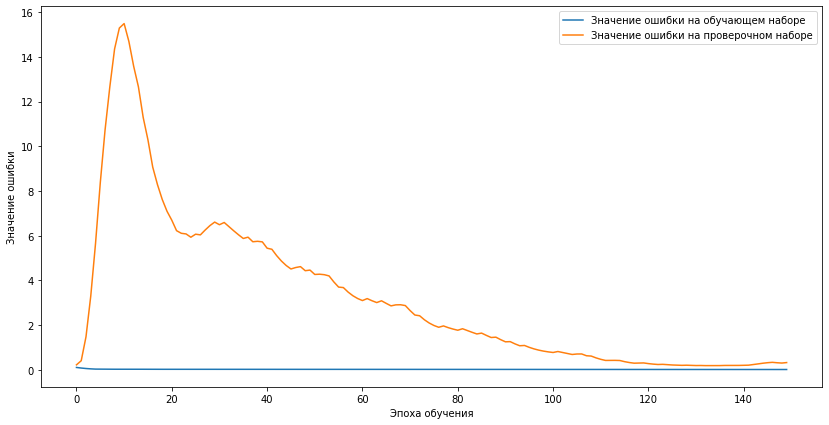

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()


In [ ]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/100
2/2 [==============================] - 1s 239ms/step - loss: 0.0173 - val_loss: 0.3059
Epoch 2/100
2/2 [==============================] - 0s 138ms/step - loss: 0.0172 - val_loss: 0.3198
Epoch 3/100
2/2 [==============================] - 0s 128ms/step - loss: 0.0172 - val_loss: 0.3297
Epoch 4/100
2/2 [==============================] - 0s 124ms/step - loss: 0.0172 - val_loss: 0.3288
Epoch 5/100
2/2 [==============================] - 0s 129ms/step - loss: 0.0172 - val_loss: 0.3370
Epoch 6/100
2/2 [==============================] - 0s 126ms/step - loss: 0.0172 - val_loss: 0.3372
Epoch 7/100
2/2 [==============================] - 0s 123ms/step - loss: 0.0172 - val_loss: 0.3446
Epoch 8/100
2/2 [==============================] - 0s 143ms/step - loss: 0.0172 - val_loss: 0.3512
Epoch 9/100
2/2 [==============================] - 0s 124ms/step - loss: 0.0172 - val_loss: 0.3572
Epoch 10/100
2/2 [==============================] - 0s 122ms/step - loss: 0.0172 - val_loss: 0.3567
Epoch 11/

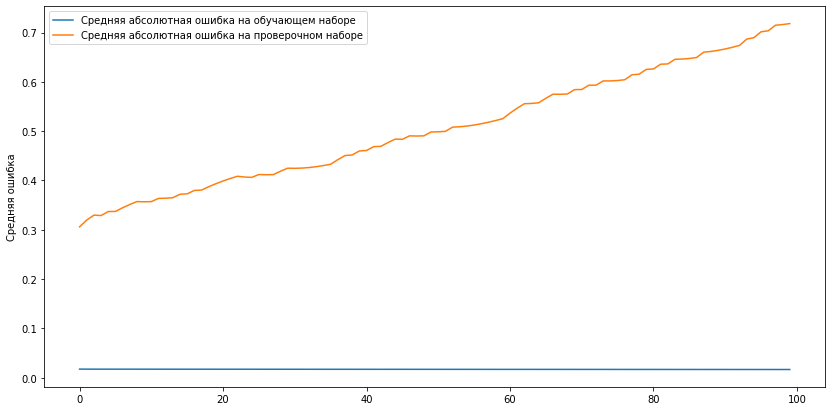

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-6))
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
2/2 [==============================] - 1s 279ms/step - loss: 0.0165 - val_loss: 0.7136
Epoch 2/50
2/2 [==============================] - 0s 148ms/step - loss: 0.0165 - val_loss: 0.7162
Epoch 3/50
2/2 [==============================] - 0s 184ms/step - loss: 0.0165 - val_loss: 0.7178
Epoch 4/50
2/2 [==============================] - 0s 174ms/step - loss: 0.0165 - val_loss: 0.7190
Epoch 5/50
2/2 [==============================] - 0s 115ms/step - loss: 0.0165 - val_loss: 0.7186
Epoch 6/50
2/2 [==============================] - 0s 175ms/step - loss: 0.0165 - val_loss: 0.7197
Epoch 7/50
2/2 [==============================] - 0s 110ms/step - loss: 0.0165 - val_loss: 0.7195
Epoch 8/50
2/2 [==============================] - 0s 181ms/step - loss: 0.0165 - val_loss: 0.7206
Epoch 9/50
2/2 [==============================] - 0s 114ms/step - loss: 0.0165 - val_loss: 0.7205
Epoch 10/50
2/2 [==============================] - 0s 109ms/step - loss: 0.0165 - val_loss: 0.7215
Epoch 11/50
2/2 [==

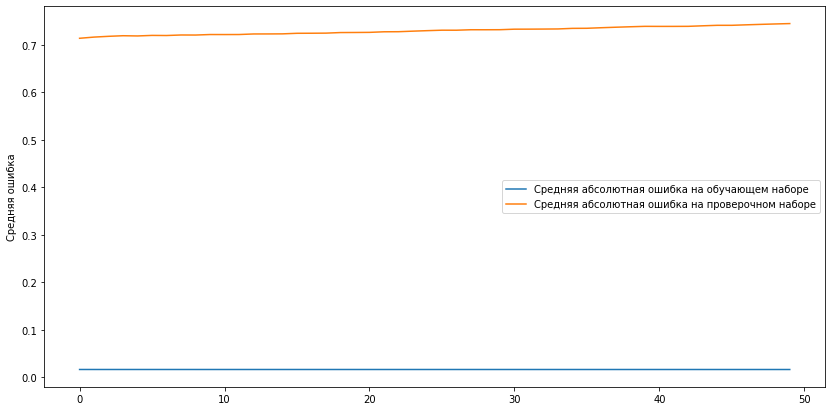

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

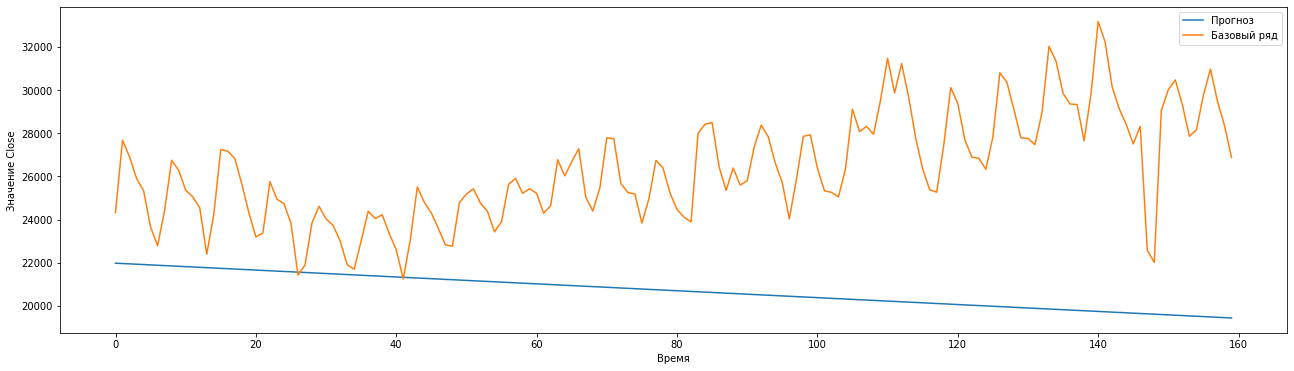

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


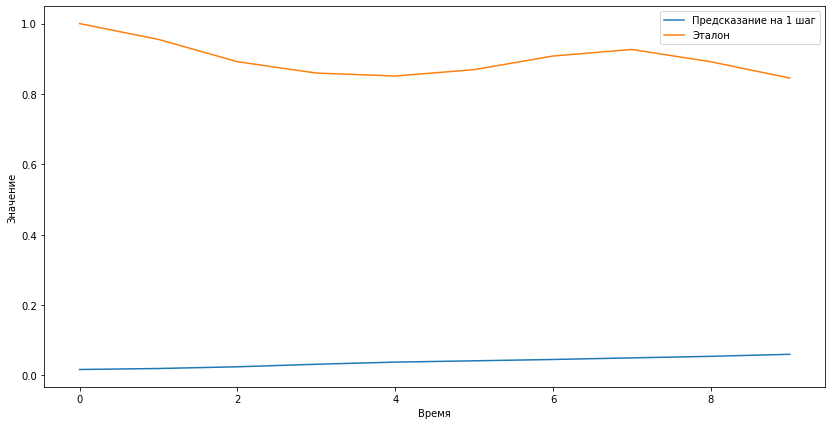

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

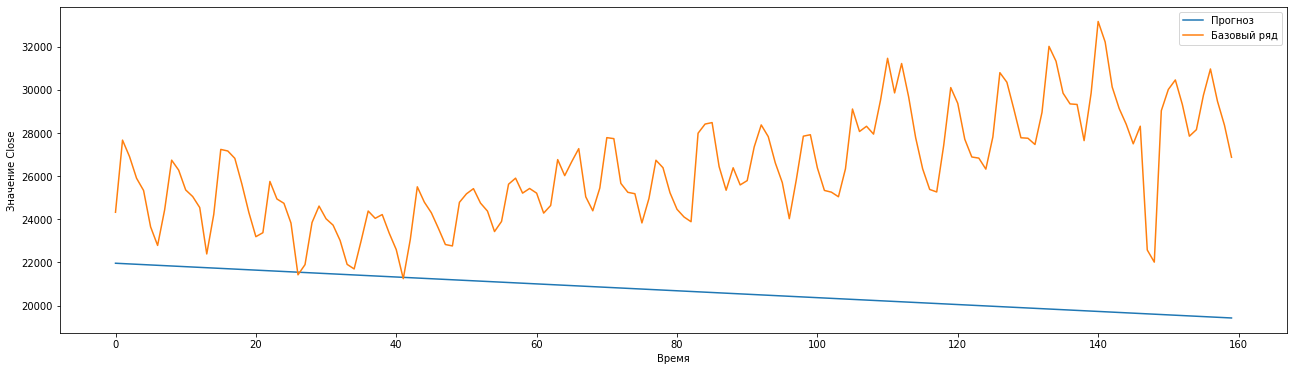

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])


### Эксп. №2

In [ ]:
#Создаём нейронку
modelD_2 = Sequential()
modelD_2.add(Flatten(input_shape = (xLen,1)))
modelD_2.add(Dense(150, activation="relu" )) # 1 - количество каналов
modelD_2.add(Dense(1, activation="linear"))

#Компилируем
modelD_2.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelD_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 60)                0         
                                                                 
 dense_22 (Dense)            (None, 150)               9150      
                                                                 
 dense_23 (Dense)            (None, 1)                 151       
                                                                 
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Запускаем обучение
history = modelD_2.fit(
                    trainDataGen, 
                    epochs=150, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/150
2/2 [==============================] - 1s 293ms/step - loss: 0.0458 - val_loss: 45.6034
Epoch 2/150
2/2 [==============================] - 0s 113ms/step - loss: 0.0410 - val_loss: 42.8949
Epoch 3/150
2/2 [==============================] - 0s 123ms/step - loss: 0.0416 - val_loss: 38.5989
Epoch 4/150
2/2 [==============================] - 0s 187ms/step - loss: 0.0383 - val_loss: 36.3035
Epoch 5/150
2/2 [==============================] - 0s 182ms/step - loss: 0.0379 - val_loss: 34.3424
Epoch 6/150
2/2 [==============================] - 0s 182ms/step - loss: 0.0377 - val_loss: 32.7344
Epoch 7/150
2/2 [==============================] - 0s 124ms/step - loss: 0.0387 - val_loss: 30.7541
Epoch 8/150
2/2 [==============================] - 0s 113ms/step - loss: 0.0379 - val_loss: 29.9826
Epoch 9/150
2/2 [==============================] - 0s 181ms/step - loss: 0.0381 - val_loss: 28.8734
Epoch 10/150
2/2 [==============================] - 0s 108ms/step - loss: 0.0378 - val_loss: 28.7344

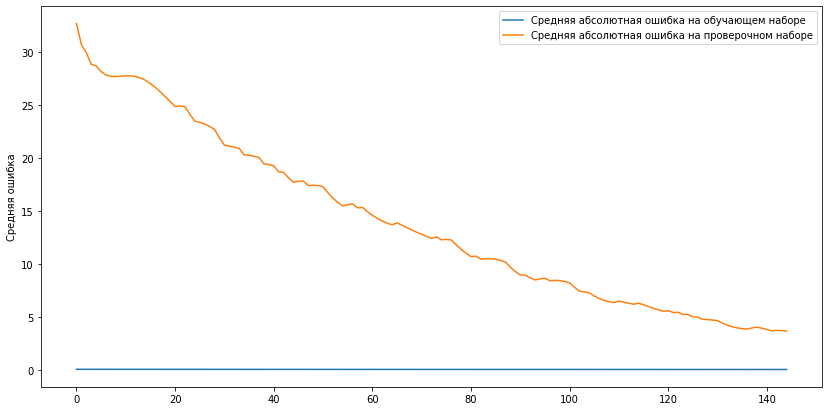

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][5:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][5:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

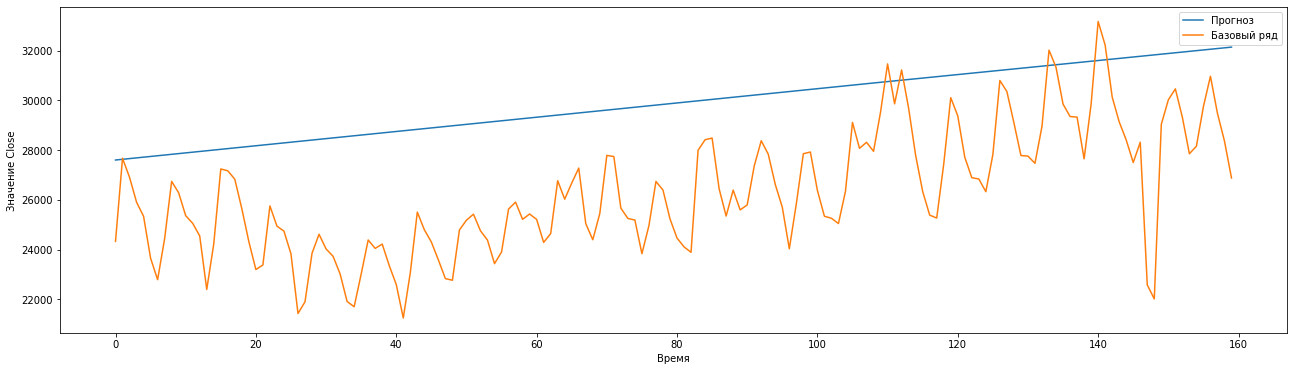

In [ ]:
#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(modelD_2, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


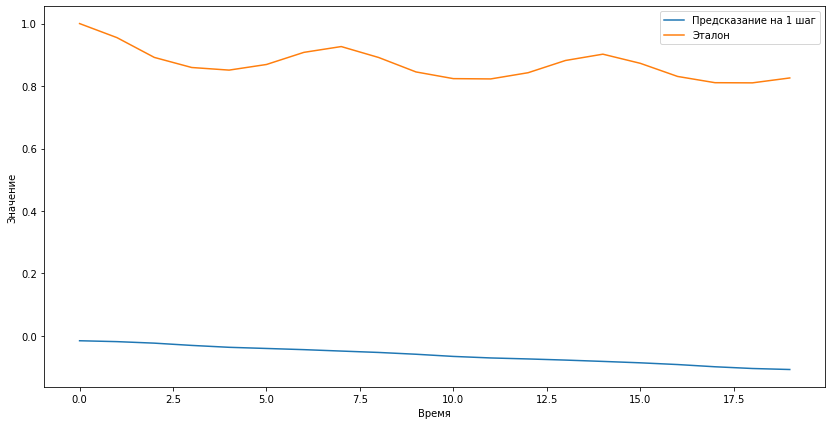

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 20, predVal, yValUnscaled)

In [ ]:
modelD_2.compile(loss="mse", optimizer=Adam(lr=1e-5))
#Запускаем обучение
history = modelD_2.fit(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/20
2/2 [==============================] - 1s 282ms/step - loss: 0.0184 - val_loss: 3.7481
Epoch 2/20
2/2 [==============================] - 0s 178ms/step - loss: 0.0183 - val_loss: 3.6676
Epoch 3/20
2/2 [==============================] - 0s 115ms/step - loss: 0.0183 - val_loss: 3.6088
Epoch 4/20
2/2 [==============================] - 0s 114ms/step - loss: 0.0183 - val_loss: 3.5610
Epoch 5/20
2/2 [==============================] - 0s 178ms/step - loss: 0.0183 - val_loss: 3.5204
Epoch 6/20
2/2 [==============================] - 0s 175ms/step - loss: 0.0182 - val_loss: 3.5139
Epoch 7/20
2/2 [==============================] - 0s 118ms/step - loss: 0.0182 - val_loss: 3.5032
Epoch 8/20
2/2 [==============================] - 0s 179ms/step - loss: 0.0182 - val_loss: 3.4896
Epoch 9/20
2/2 [==============================] - 0s 112ms/step - loss: 0.0182 - val_loss: 3.4740
Epoch 10/20
2/2 [==============================] - 0s 124ms/step - loss: 0.0182 - val_loss: 3.4341
Epoch 11/20
2/2 [==

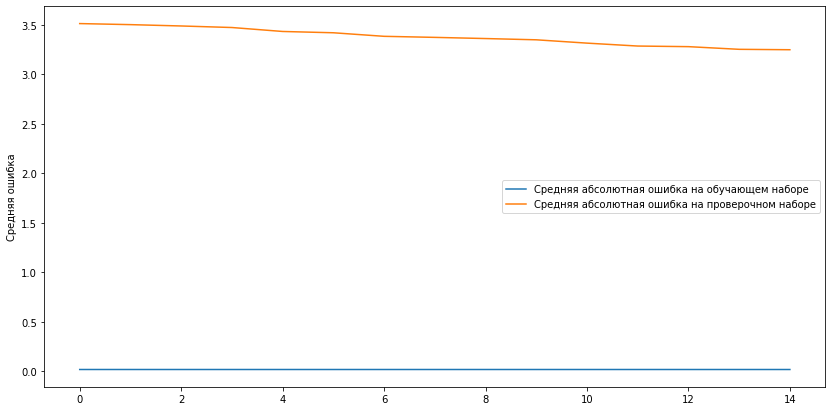

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][5:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][5:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

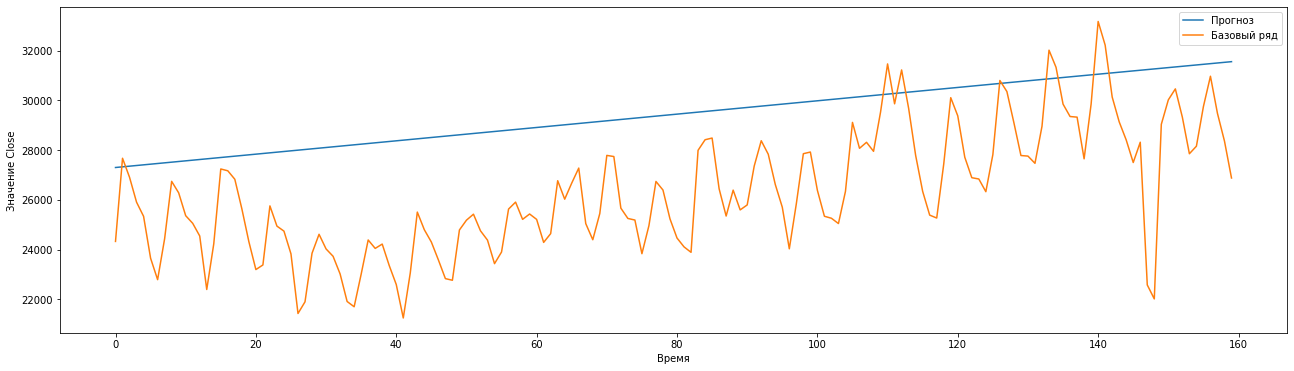

In [ ]:
#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(modelD_2, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


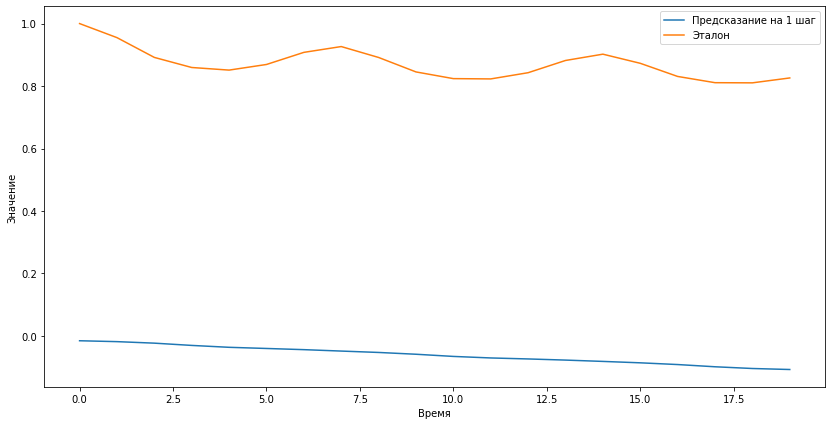

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 20, predVal, yValUnscaled)

## Одномерная свёртка



In [ ]:
modelC = Sequential()

modelC.add(Conv1D(64, 1, input_shape = (xLen,1), activation="relu"))
modelC.add(Conv1D(64, 1, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 60, 64)            128       
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 64)            4160      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 flatten_15 (Flatten)        (None, 1920)              0         
                                                                 
 dense_26 (Dense)            (None, 100)               192100    
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                     

In [ ]:
history = modelC.fit(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/50
2/2 [==============================] - 1s 302ms/step - loss: 0.0571 - val_loss: 1.0847
Epoch 2/50
2/2 [==============================] - 0s 169ms/step - loss: 0.0417 - val_loss: 3.0770
Epoch 3/50
2/2 [==============================] - 0s 181ms/step - loss: 0.0278 - val_loss: 5.2956
Epoch 4/50
2/2 [==============================] - 0s 159ms/step - loss: 0.0248 - val_loss: 7.2110
Epoch 5/50
2/2 [==============================] - 0s 178ms/step - loss: 0.0275 - val_loss: 8.9782
Epoch 6/50
2/2 [==============================] - 0s 185ms/step - loss: 0.0276 - val_loss: 9.7311
Epoch 7/50
2/2 [==============================] - 0s 188ms/step - loss: 0.0275 - val_loss: 9.6235
Epoch 8/50
2/2 [==============================] - 0s 170ms/step - loss: 0.0267 - val_loss: 8.9821
Epoch 9/50
2/2 [==============================] - 0s 165ms/step - loss: 0.0266 - val_loss: 7.7055
Epoch 10/50
2/2 [==============================] - 0s 184ms/step - loss: 0.0256 - val_loss: 6.5174
Epoch 11/50
2/2 [==

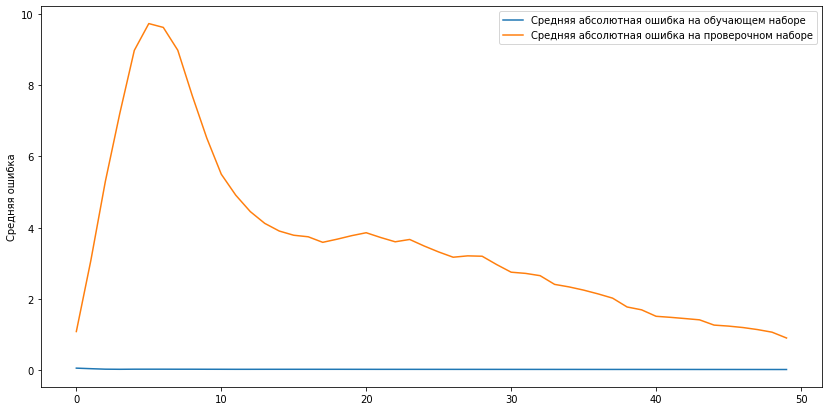

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

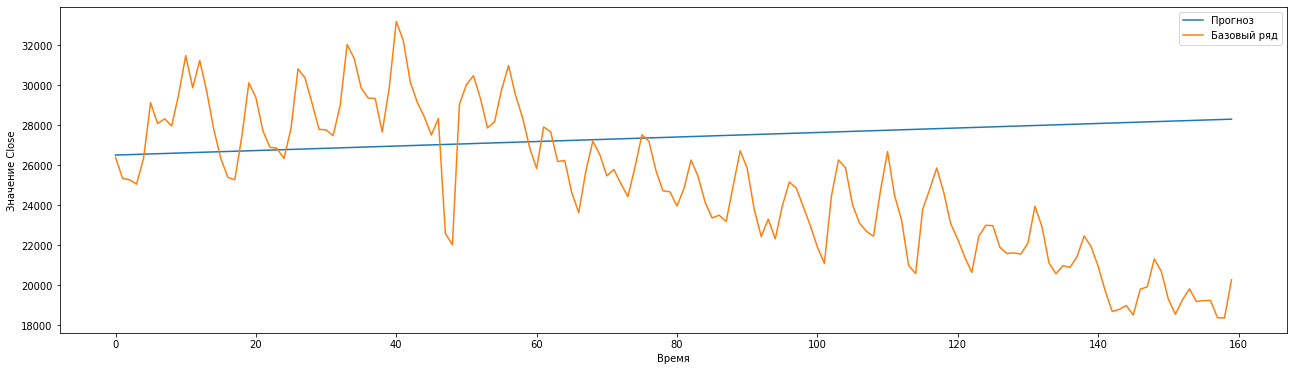

In [ ]:
#Отображаем графики
showPredict(100, 160, 0, predVal, yValUnscaled)

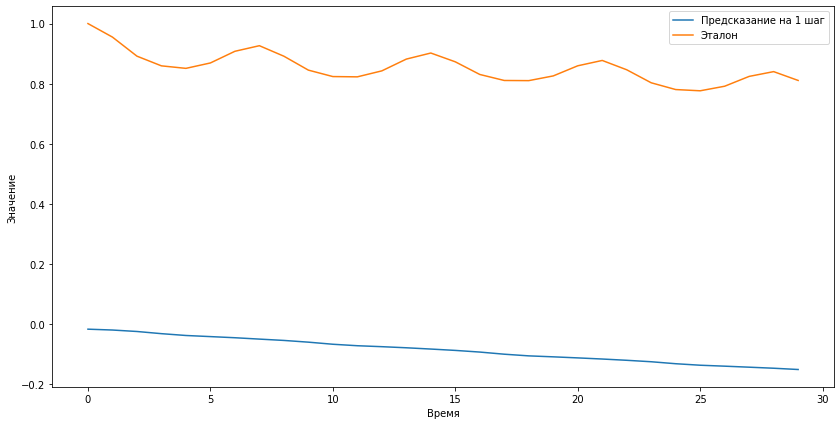

In [ ]:
#Отображаем корреляцию
showCorr([0], 30, predVal, yValUnscaled)

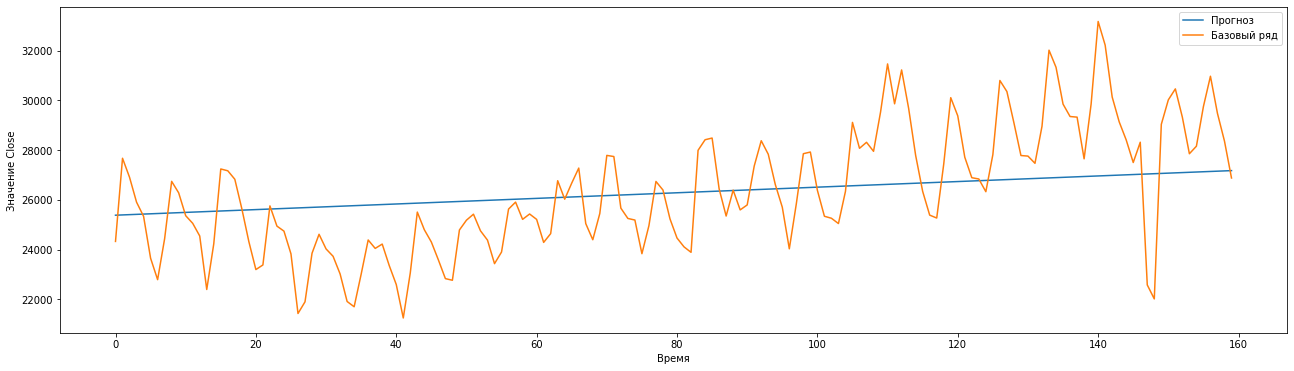

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])


In [ ]:
modelC.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelC.fit(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/20
2/2 [==============================] - 1s 239ms/step - loss: 0.0187 - val_loss: 0.8450
Epoch 2/20
2/2 [==============================] - 0s 178ms/step - loss: 0.0186 - val_loss: 0.8648
Epoch 3/20
2/2 [==============================] - 0s 124ms/step - loss: 0.0185 - val_loss: 0.8494
Epoch 4/20
2/2 [==============================] - 0s 131ms/step - loss: 0.0185 - val_loss: 0.8581
Epoch 5/20
2/2 [==============================] - 0s 126ms/step - loss: 0.0184 - val_loss: 0.8462
Epoch 6/20
2/2 [==============================] - 0s 121ms/step - loss: 0.0184 - val_loss: 0.8367
Epoch 7/20
2/2 [==============================] - 0s 176ms/step - loss: 0.0184 - val_loss: 0.8287
Epoch 8/20
2/2 [==============================] - 0s 175ms/step - loss: 0.0183 - val_loss: 0.8219
Epoch 9/20
2/2 [==============================] - 0s 129ms/step - loss: 0.0183 - val_loss: 0.8159
Epoch 10/20
2/2 [==============================] - 0s 126ms/step - loss: 0.0183 - val_loss: 0.8104
Epoch 11/20
2/2 [==

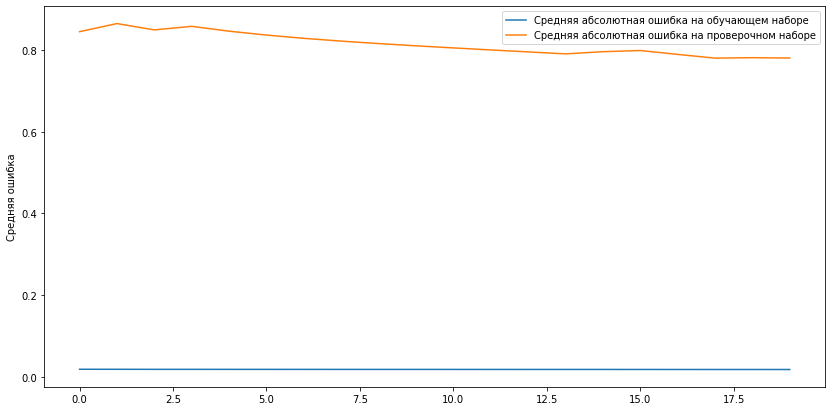

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

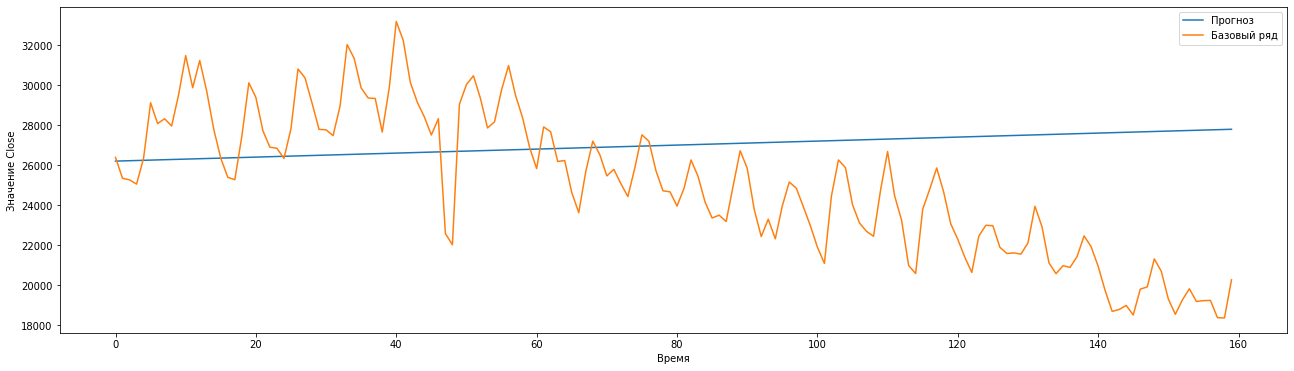

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)
#Отображаем графики
showPredict(100, 160, 0, predVal, yValUnscaled)

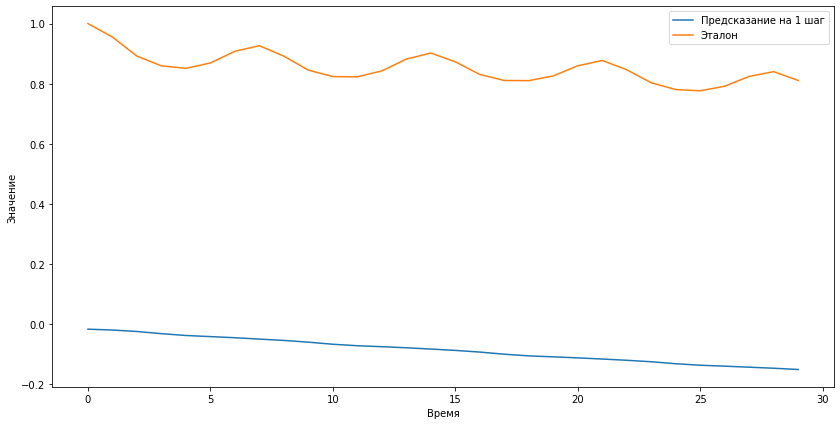

In [ ]:
#Отображаем корреляцию
showCorr([0], 30, predVal, yValUnscaled)

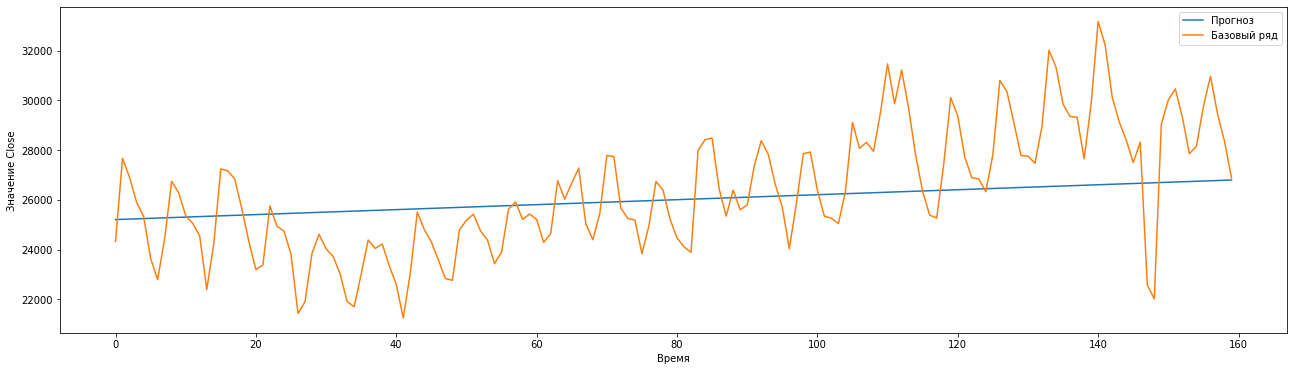

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])


## LSTM


In [ ]:
import tensorflow
modelL = Sequential()
modelL.add(LSTM(5, input_shape = (xLen, 1)))
modelL.add(Dense(10, activation="relu"))
modelL.add(Dense(1, activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

modelL.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense_28 (Dense)            (None, 10)                60        
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = modelL.fit(trainDataGen, 
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/20
2/2 [==============================] - 22s 20s/step - loss: 0.0776 - val_loss: 0.2367
Epoch 2/20
2/2 [==============================] - 0s 241ms/step - loss: 0.0776 - val_loss: 0.2368
Epoch 3/20
2/2 [==============================] - 0s 229ms/step - loss: 0.0775 - val_loss: 0.2369
Epoch 4/20
2/2 [==============================] - 0s 244ms/step - loss: 0.0774 - val_loss: 0.2369
Epoch 5/20
2/2 [==============================] - 0s 221ms/step - loss: 0.0774 - val_loss: 0.2370
Epoch 6/20
2/2 [==============================] - 0s 219ms/step - loss: 0.0773 - val_loss: 0.2370
Epoch 7/20
2/2 [==============================] - 0s 230ms/step - loss: 0.0772 - val_loss: 0.2371
Epoch 8/20
2/2 [==============================] - 0s 216ms/step - loss: 0.0772 - val_loss: 0.2372
Epoch 9/20
2/2 [==============================] - 0s 228ms/step - loss: 0.0771 - val_loss: 0.2372
Epoch 10/20
2/2 [==============================] - 0s 207ms/step - loss: 0.0771 - val_loss: 0.2373
Epoch 11/20
2/2 [===

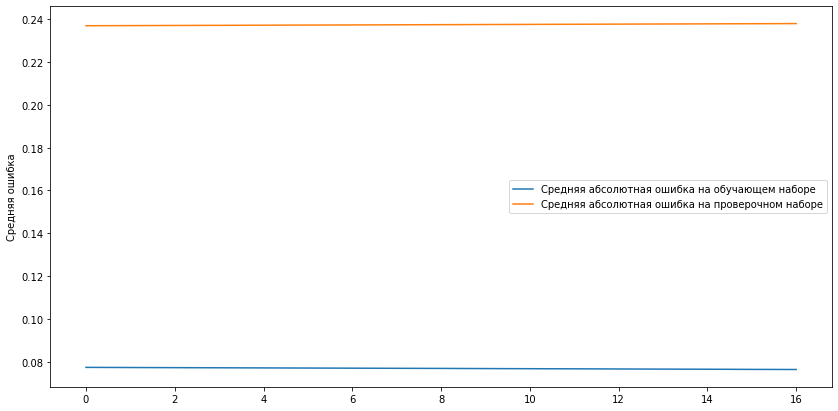

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][3:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][3:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(modelL, xVal[0], yVal[0], yScaler)

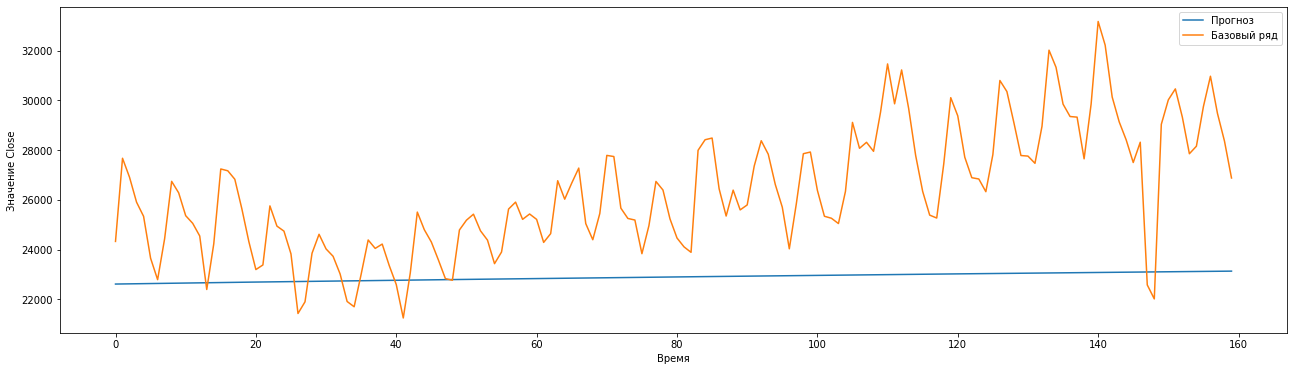

In [ ]:
#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

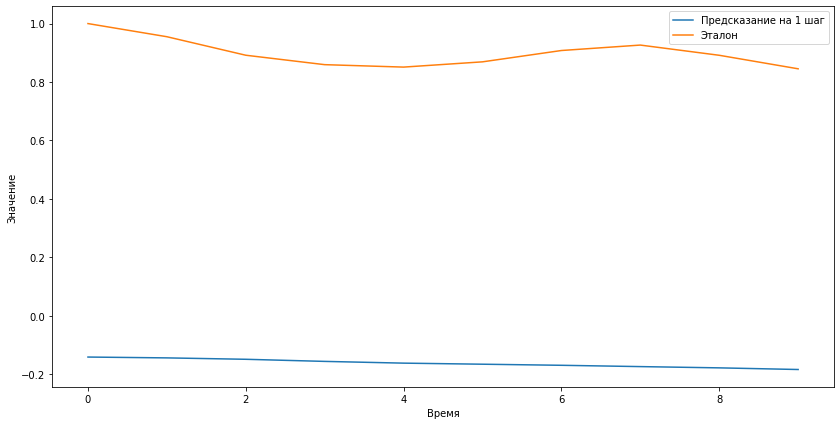

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

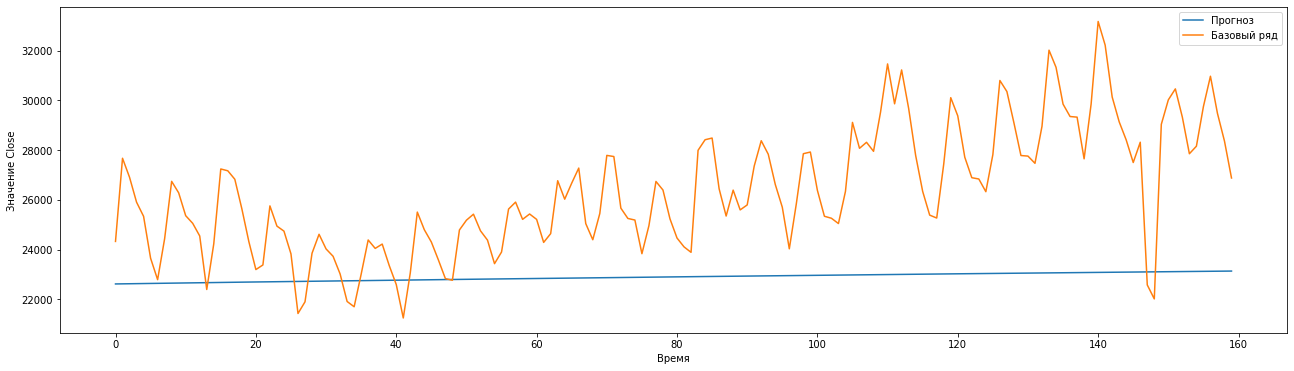

In [ ]:
#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(modelL, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])